<a href="https://colab.research.google.com/github/vit050587/neural_networks/blob/master/KVA_INN_HW_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание:

* обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) - (размерность снижается, а количество фильтров становится больше) на датасете cifar-10

* оценить рост точности при увеличении ширины сети (больше фильтров т.е. количества каналов на свёртках)

* оценить рост точности при увеличении глубины сети (больше слоев конволюций-пулингов)

*сравнить с точностью полносвязной сети для этой выборки

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Concatenate,
                                     Average, Maximum, Add, Subtract, Multiply,
                                    GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D)
from tensorflow.keras.datasets import cifar10

# 1. Обучим рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) - (размерность снижается, а количество фильтров становится больше) на датасете cifar-10

In [2]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [3]:
# загрузка тренировочных и тестовых данных
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

# нормализация данных [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# изменение размерности массива в 4D массив
# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
# X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

170498071/170498071 [==============================] - 3s 0us/step
X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [4]:
# установка параметров нейросети
batch_size = 512
num_classes = 10
epochs = 5
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

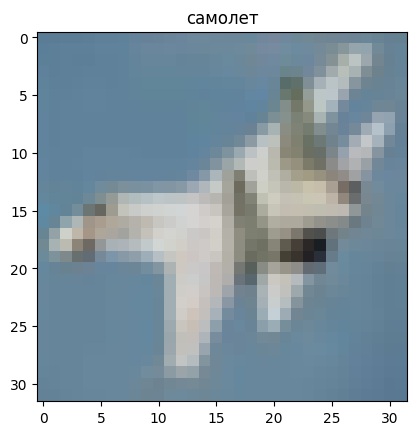

In [5]:
N = 10

plt.imshow(X_test[N])
plt.title(classes[np.argmax(y_test[N,:])])
plt.show()

In [6]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu')) # активацию можно прописывать как в самом слое, так и отдельно
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
model.add(Flatten()) 
# полносвязный слой
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
# выходной слой с функцией активации softmax
model.add(Activation('softmax'))

model.summary()

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [7]:
# Обучаем модель
hist = model.fit(X_train, y_train,
                 epochs=20,
                 batch_size=16,
                 validation_data=(X_test, y_test),
                 verbose=1)

test_loss, test_metric = model.evaluate(X_test, y_test)
print(f"Test loss {test_loss:.4f}, accuracy {test_metric:.2f}%")

Epoch 1/20
3125/3125 [==============================] - 311s 98ms/step - loss: 1.9823 - accuracy: 0.2688 - val_loss: 1.7004 - val_accuracy: 0.3842
Epoch 2/20
3125/3125 [==============================] - 318s 102ms/step - loss: 1.6456 - accuracy: 0.4006 - val_loss: 1.4260 - val_accuracy: 0.4861
Epoch 3/20
3125/3125 [==============================] - 308s 99ms/step - loss: 1.4413 - accuracy: 0.4777 - val_loss: 1.2779 - val_accuracy: 0.5418
Epoch 4/20
3125/3125 [==============================] - 314s 100ms/step - loss: 1.3062 - accuracy: 0.5318 - val_loss: 1.1901 - val_accuracy: 0.5810
Epoch 5/20
3125/3125 [==============================] - 315s 101ms/step - loss: 1.2106 - accuracy: 0.5689 - val_loss: 1.0954 - val_accuracy: 0.6140
Epoch 6/20
3125/3125 [==============================] - 315s 101ms/step - loss: 1.1285 - accuracy: 0.6017 - val_loss: 1.0280 - val_accuracy: 0.6367
Epoch 7/20
3125/3125 [==============================] - 308s 99ms/step - loss: 1.0585 - accuracy: 0.6279 - val_los

In [8]:
y_pred = model.predict(X_test)

313/313 [==============================] - 13s 41ms/step


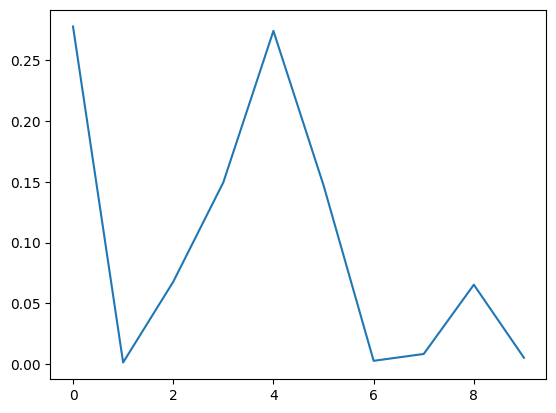

[0.27780378 0.00143844 0.06779153 0.14957073 0.27417296 0.1472187
 0.00280974 0.00843353 0.06539339 0.00536721]


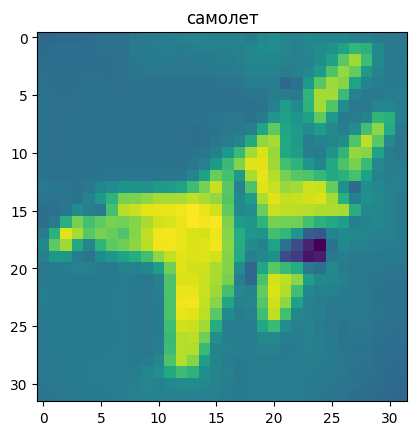

In [9]:
N = 10
plt.plot(y_pred[N][:])
plt.show()
print(y_pred[N][:])
plt.imshow(X_test[N][:,:,0])
plt.title(classes[np.argmax(y_test[N,:])])
plt.show()

# 2. Оценим рост точности при увеличении ширины сети (больше фильтров т.е. количества каналов на свёртках)

In [10]:
# конфигурирование слоев нейросети
model_2 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_2.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_2.add(Activation('relu')) # активацию можно прописывать как в самом слое, так и отдельно
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(256, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

# полносвязные слои нейронной сети
# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
model_2.add(Flatten()) 
# полносвязный слой
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
# выходной слой с функцией активации softmax
model_2.add(Activation('softmax'))

model_2.summary()

# компиляция модели
model_2.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 activation_7 (Activation)   (None, 30, 30, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 64)        0         
                                                      

In [11]:
# Обучаем модель
hist = model_2.fit(X_train, y_train,
                 epochs=10,
                 batch_size=16,
                 validation_data=(X_test, y_test),
                 verbose=1)

test_loss, test_metric = model_2.evaluate(X_test, y_test)
print(f"Test loss {test_loss:.4f}, accuracy {test_metric:.2f}%")

Epoch 1/10
3125/3125 [==============================] - 850s 272ms/step - loss: 1.9495 - accuracy: 0.2875 - val_loss: 1.6141 - val_accuracy: 0.4213
Epoch 2/10
3125/3125 [==============================] - 847s 271ms/step - loss: 1.5344 - accuracy: 0.4410 - val_loss: 1.3292 - val_accuracy: 0.5158
Epoch 3/10
3125/3125 [==============================] - 844s 270ms/step - loss: 1.3324 - accuracy: 0.5193 - val_loss: 1.1886 - val_accuracy: 0.5760
Epoch 4/10
3125/3125 [==============================] - 849s 272ms/step - loss: 1.1974 - accuracy: 0.5712 - val_loss: 1.0646 - val_accuracy: 0.6273
Epoch 5/10
3125/3125 [==============================] - 845s 270ms/step - loss: 1.0745 - accuracy: 0.6182 - val_loss: 0.9493 - val_accuracy: 0.6691
Epoch 6/10
3125/3125 [==============================] - 845s 270ms/step - loss: 0.9799 - accuracy: 0.6544 - val_loss: 0.8932 - val_accuracy: 0.6822
Epoch 7/10
3125/3125 [==============================] - 844s 270ms/step - loss: 0.8979 - accuracy: 0.6835 - val_

**Вывод**: С увеличением ширины сети качество упало - с 0.7754 до 0.7560

# 3. Оценим рост точности при увеличении глубины сети (больше слоев конволюций-пулингов)

In [12]:
# конфигурирование слоев нейросети
model_3 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_3.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_3.add(Activation('relu')) # активацию можно прописывать как в самом слое, так и отдельно
model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))
# больше слоёв конволюций-пуллингов
model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

# полносвязные слои нейронной сети
# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
model_3.add(Flatten()) 
# полносвязный слой
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
# выходной слой с функцией активации softmax
model_3.add(Activation('softmax'))

model_3.summary()

# компиляция модели
model_3.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                      

In [13]:
# Обучаем модель
hist = model_3.fit(X_train, y_train,
                 epochs=10,
                 batch_size=16,
                 validation_data=(X_test, y_test),
                 verbose=1)

test_loss, test_metric = model_3.evaluate(X_test, y_test)
print(f"Test loss {test_loss:.4f}, accuracy {test_metric:.2f}%")

Epoch 1/10
3125/3125 [==============================] - 310s 99ms/step - loss: 2.1753 - accuracy: 0.1778 - val_loss: 1.9330 - val_accuracy: 0.2882
Epoch 2/10
3125/3125 [==============================] - 315s 101ms/step - loss: 1.8286 - accuracy: 0.3191 - val_loss: 1.6117 - val_accuracy: 0.4020
Epoch 3/10
3125/3125 [==============================] - 307s 98ms/step - loss: 1.5733 - accuracy: 0.4190 - val_loss: 1.4107 - val_accuracy: 0.4892
Epoch 4/10
3125/3125 [==============================] - 307s 98ms/step - loss: 1.4210 - accuracy: 0.4792 - val_loss: 1.2806 - val_accuracy: 0.5324
Epoch 5/10
3125/3125 [==============================] - 315s 101ms/step - loss: 1.3104 - accuracy: 0.5249 - val_loss: 1.1643 - val_accuracy: 0.5824
Epoch 6/10
3125/3125 [==============================] - 314s 101ms/step - loss: 1.2308 - accuracy: 0.5588 - val_loss: 1.0963 - val_accuracy: 0.6049
Epoch 7/10
3125/3125 [==============================] - 306s 98ms/step - loss: 1.1606 - accuracy: 0.5869 - val_loss

**Вывод**: При увеличении глубины сети (увеличении количества слоёв конволюций-пулингов) качество упало ещё сильнее - до 0.6916.

# 4. *сравнение с точностью полносвязной сети для этой выборки

In [14]:
# конфигурирование слоев нейросети
model_4 = Sequential()

# полносвязные слои нейронной сети
# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
model_4.add(Flatten(input_shape=X_train.shape[1:]))
# полносвязный слой
model_4.add(Dense(512))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(num_classes))
# выходной слой с функцией активации softmax
model_4.add(Activation('softmax'))

model_4.summary()

# компиляция модели
model_4.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1573376   
                                                                 
 activation_20 (Activation)  (None, 512)               0         
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
 activation_21 (Activation)  (None, 10)                0         
                                                                 
Total params: 1,578,506
Trainable params: 1,578,506
No

In [15]:
# Обучаем модель
hist = model_4.fit(X_train, y_train,
                 epochs=10,
                 batch_size=16,
                 validation_data=(X_test, y_test),
                 verbose=1)

test_loss, test_metric = model_4.evaluate(X_test, y_test)
print(f"Test loss {test_loss:.4f}, accuracy {test_metric:.2f}%")

Epoch 1/10
3125/3125 [==============================] - 31s 10ms/step - loss: 1.9375 - accuracy: 0.3004 - val_loss: 1.7495 - val_accuracy: 0.3782
Epoch 2/10
3125/3125 [==============================] - 31s 10ms/step - loss: 1.7894 - accuracy: 0.3586 - val_loss: 1.7178 - val_accuracy: 0.3772
Epoch 3/10
3125/3125 [==============================] - 30s 10ms/step - loss: 1.7327 - accuracy: 0.3838 - val_loss: 1.6336 - val_accuracy: 0.4205
Epoch 4/10
3125/3125 [==============================] - 29s 9ms/step - loss: 1.6939 - accuracy: 0.3984 - val_loss: 1.5998 - val_accuracy: 0.4376
Epoch 5/10
3125/3125 [==============================] - 31s 10ms/step - loss: 1.6655 - accuracy: 0.4077 - val_loss: 1.5712 - val_accuracy: 0.4578
Epoch 6/10
3125/3125 [==============================] - 29s 9ms/step - loss: 1.6407 - accuracy: 0.4172 - val_loss: 1.5512 - val_accuracy: 0.4584
Epoch 7/10
3125/3125 [==============================] - 30s 10ms/step - loss: 1.6192 - accuracy: 0.4251 - val_loss: 1.5316 - v

**Вывод**: Полносвзная сеть обеспечила самое низкое качество.